In [4]:
import os
import glob
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import logging
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer, silhouette_score

# Настройка логирования
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Загрузка необходимых данных для nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Функция предобработки текста
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Удаление спецсимволов
    text = re.sub(r'\s+', ' ', text)  # Удаление лишних пробелов
    words = word_tokenize(text.lower())  # Токенизация и приведение к нижнему регистру
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]  # Лемматизация
    return ' '.join(words)

# Чтение и предобработка документов
def load_and_preprocess_documents(folder_path):
    file_paths = glob.glob(os.path.join(folder_path, "*.txt"))
    if not file_paths:
        logging.error(f"Нет документов в папке: {folder_path}")
        return []
    
    documents = []
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            processed_text = preprocess_text(text)
            documents.append(processed_text)
    
    logging.info(f"Прочитано {len(documents)} документов.")
    return documents

folder_path = r'C:\Users\artem\Downloads\sampled_texts\sampled_texts'
documents = load_and_preprocess_documents(folder_path)
if not documents:
    raise ValueError("Не удалось загрузить документы.")

# Загрузка предобученной модели для создания эмбеддингов
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(documents)

logging.info(f"Эмбеддинги документов успешно получены. Размер эмбеддингов: {embeddings.shape}")

# Определение метрики силуэта для оценки качества кластеров
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    return silhouette_score(X, labels)

# Параметры для подбора с помощью GridSearch
param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],  # Количество кластеров
    'init': ['k-means++', 'random'],  # Метод инициализации
    'n_init': [10, 20],  # Количество запусков KMeans
    'max_iter': [300, 600]  # Максимальное количество итераций
}

# Инициализация KMeans
kmeans = KMeans(random_state=42)

# GridSearchCV для подбора оптимальных параметров
grid_search = GridSearchCV(kmeans, param_grid, scoring=make_scorer(silhouette_scorer), cv=3, verbose=1)
grid_search.fit(embeddings)

# Лучшие параметры KMeans
best_kmeans = grid_search.best_estimator_
logging.info(f"Лучшие параметры KMeans: {grid_search.best_params_}")

# Присваивание кластеров каждому документу
clusters = best_kmeans.labels_
logging.info(f"Документы распределены по кластерам: {clusters}")

# Классификация нового документа с использованием NearestNeighbors
def classify_new_document(new_document_path, model, embeddings, clusters):
    if not os.path.exists(new_document_path):
        logging.error(f"Файл {new_document_path} не найден.")
        return
    
    with open(new_document_path, 'r', encoding='utf-8') as file:
        new_document = file.read()
    
    # Предобработка нового документа
    processed_new_document = preprocess_text(new_document)
    new_document_embedding = model.encode([processed_new_document])
    
    # Подбор гиперпараметров для NearestNeighbors через ручной подбор
    param_grid_nn = {
        'n_neighbors': [1, 3, 5],  # Количество соседей
        'metric': ['cosine', 'euclidean', 'manhattan']  # Метрика
    }
    
    best_params = None
    best_distance = float('inf')
    best_nn = None

    # Ручной поиск лучших параметров
    for n_neighbors in param_grid_nn['n_neighbors']:
        for metric in param_grid_nn['metric']:
            nn = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
            nn.fit(embeddings)
            distance, index = nn.kneighbors(new_document_embedding)
            avg_distance = np.mean(distance)
            
            if avg_distance < best_distance:
                best_distance = avg_distance
                best_params = {'n_neighbors': n_neighbors, 'metric': metric}
                best_nn = nn

    logging.info(f"Лучшие параметры NearestNeighbors: {best_params}")

    # Поиск ближайшего кластера с лучшими параметрами
    distance, index = best_nn.kneighbors(new_document_embedding)
    nearest_cluster = clusters[index[0][0]]
    
    logging.info(f"Новый документ отнесен к кластеру: {nearest_cluster}")
    return nearest_cluster

# Пример классификации нового документа
new_document_path = r'C:\Users\artem\Downloads\new_documents.txt'
classify_new_document(new_document_path, model, embeddings, clusters)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\artem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - 'C:\\Users\\artem/nltk_data'
    - 'c:\\lad_academy\\myenv\\nltk_data'
    - 'c:\\lad_academy\\myenv\\share\\nltk_data'
    - 'c:\\lad_academy\\myenv\\lib\\nltk_data'
    - 'C:\\Users\\artem\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


<Figure size 1000x600 with 0 Axes>

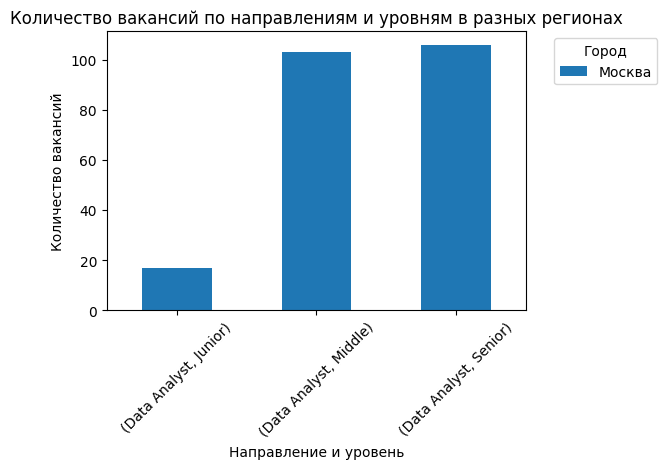

In [9]:
import matplotlib.pyplot as plt
# Построение графика
plt.figure(figsize=(10, 6))
df.groupby(['Направление', 'Уровень', 'Город'])['Количество вакансий'].sum().unstack().plot(kind='bar', stacked=True)
plt.title('Количество вакансий по направлениям и уровням в разных регионах')
plt.ylabel('Количество вакансий')
plt.xlabel('Направление и уровень')
plt.xticks(rotation=45)
plt.legend(title='Город', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Сохранение графика
plt.savefig('vacancies_plot.png')
plt.show()